### Plot a batch of neural activty sequences from train and validation datasets.
---
*Last updated: 13 November 2023*

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import TwoSlopeNorm
from matplotlib.collections import LineCollection
from utils import NEURON_LABELS, init_random_seeds

# Initialize the random seeds
init_random_seeds(42)

Loading from /orcd/home/001/qsimeon/worm-graph/data/raw/neuron_master_sheet.csv.

CUDA device found.
	 GPU: NVIDIA H100 80GB HBM3


### Debugging

In [ ]:
from omegaconf import DictConfig, OmegaConf
from data._utils import load_dataset, select_desired_worms, select_labeled_neurons, rename_worm_keys

data_config = OmegaConf.load("configs/submodule/data.yaml")
print(OmegaConf.to_yaml(data_config), end="\n\n")


# Parse out parameters from the config
source_datasets = data_config.source_datasets
num_labeled_neurons = data_config.num_labeled_neurons
num_train_samples = data_config.num_train_samples
num_val_samples = data_config.num_val_samples
seq_len = data_config.seq_len
reverse = data_config.reverse
use_residual = data_config.use_residual
use_smooth = data_config.use_smooth
train_split_first = data_config.train_split_first
train_split_ratio = data_config.train_split_ratio
save = True  # data_config.save_datasets

# TODO: This should return a .pt file instead of a pickle file for `combined_dataset`.

# Convert DictConfig to dict
if isinstance(source_datasets, DictConfig):
    source_datasets = OmegaConf.to_object(source_datasets)

# Load the dataset(s)
combined_dataset = dict()

for dataset_name, worms in source_datasets.items():
    # Skip if no worms requested for this dataset
    if worms is None or worms == 0:
        print(f"Skipping all worms from {dataset_name} dataset.")
        continue

    # Create a multi-worm dataset
    multi_worms_dataset = load_dataset(dataset_name)

    # Select desired worms from this dataset
    multi_worms_dataset = select_desired_worms(multi_worms_dataset, worms)

    # Select the `num_labeled_neurons` neurons and overwrite the masks
    multi_worms_dataset = select_labeled_neurons(multi_worms_dataset, num_labeled_neurons)

    # Add the worms from this dataset to the combined dataset
    for worm in multi_worms_dataset:
        if worm in combined_dataset:
            worm_ = max([int(key.split("worm")[-1]) for key in combined_dataset.keys()]) + 1
            worm_ = "worm" + str(worm_)
            combined_dataset[worm_] = multi_worms_dataset[worm]
            combined_dataset[worm_]["worm"] = worm_
            combined_dataset[worm_]["original_worm"] = worm
        else:
            combined_dataset[worm] = multi_worms_dataset[worm]
            combined_dataset[worm]["original_worm"] = worm

# Rename the worm keys so that they are ordered
combined_dataset = rename_worm_keys(combined_dataset)

In [ ]:
### DEBUG ###

In [ ]:
### DEBUG ###




NeuralActivityDataset(
data=train_split.detach(),
time_vec=train_time_split.detach(),
neurons_mask=neurons_mask,
wormID=original_worm_id,  # worm ID from the original experimental dataset
worm_dataset=worm_dataset,  # name of the original experimental dataset the data is from
seq_len=seq_len,
num_samples=num_train_samples_split,
use_residual=use_residual,
reverse=reverse,
)
)

In [ ]:
combined_dataset = pickle.load(f"datasets/combined_dataset.pickle")
combined_dataset, dataset_info = filter_loaded_combined_dataset(
    combined_dataset,
    data_config.use_these_datasets.num_worms,
    num_labeled_neurons,
)

combined_dataset
for wormID, single_worm_dataset in combined_dataset.items():
    # TODO: Encapsulate this inner part as a function `split_single_dataset`.
    # Extract relevant features from the dataset
    data = single_worm_dataset[key_data]
    neurons_mask = single_worm_dataset["labeled_neurons_mask"]
    time_vec = single_worm_dataset["time_in_seconds"]
    worm_dataset = single_worm_dataset["source_dataset"]
    original_worm_id = single_worm_dataset["original_worm"]

    NeuralActivityDataset(
        data=data.detach(),
        time_vec=time_vec.detach(),
        neurons_mask=neurons_mask,
        wormID=original_worm_id,  # worm ID from the original experimental dataset
        worm_dataset=worm_dataset,  # name of the original experimental dataset the data is from
        seq_len=seq_len,
        num_samples=num_train_samples_split,
        use_residual=use_residual,
        reverse=reverse,
    )

    # Concatenate the datasets
    train_dataset = (
        torch.utils.data.ConcatDataset(train_dataset) if len(train_dataset) else None
    )  # number of train sequences = number train samples * number of worms

In [3]:
# Choose path to dataset folder containing the train and validation splits
datadir = "."

# Choose the train or test dataset
train_or_test = "test"
if train_or_test.lower() == "train":
    dataset = torch.load(os.path.join(datadir, "train_AllExperimental", "train_dataset.pt"))
elif train_or_test.lower() == "test":
    dataset = torch.load(os.path.join(datadir, "validation_AllExperimental", "val_dataset.pt"))

# Get the first batch of data
X, Y, mask, info = next(iter(dataset))

# Select the measure neurons using the mask
neurons = np.array(NEURON_LABELS)[mask]
print(f"\tneurons: {neurons.shape}\n")

# Convert tensor to numpy for easier handling
data = X[:, mask].numpy()
print(f"\tdata: {data.shape}\n")

# Time or index - replace this with actual time if needed
time = info["time_vec"].numpy()
print(f"\ttime: {time.shape}\n")

	neurons: (45,)

	data: (180, 45)

	time: (180,)



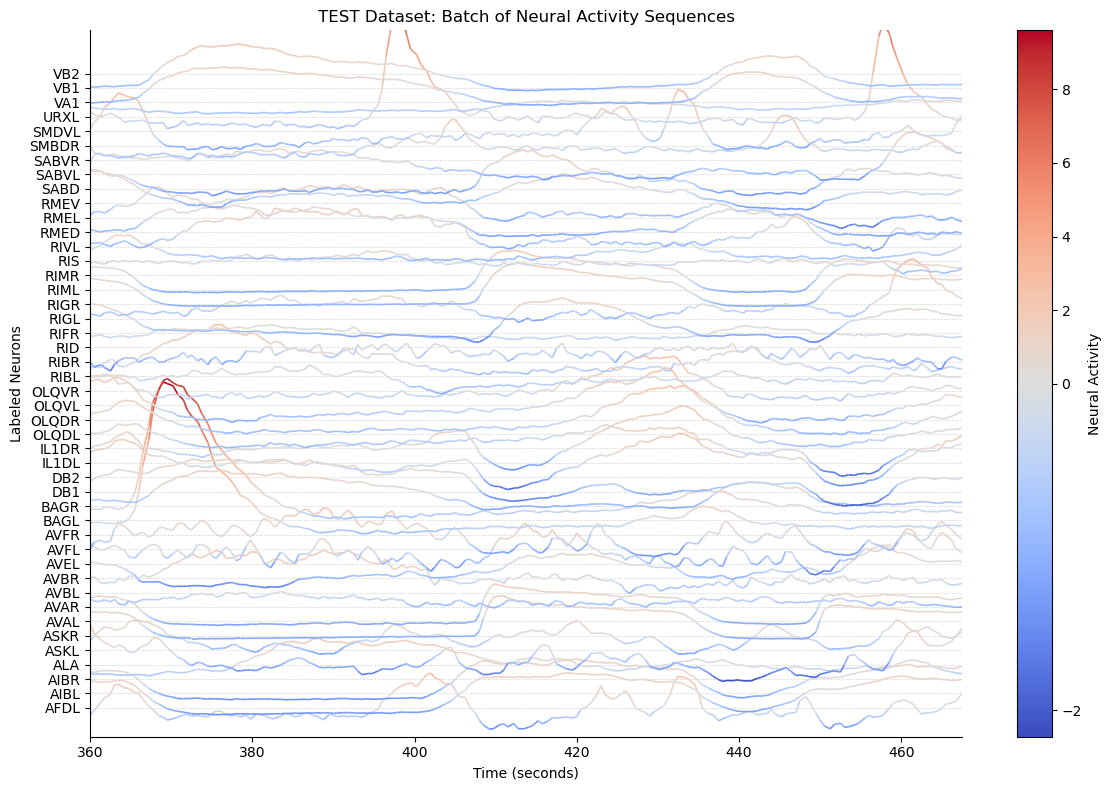

In [4]:
# Set figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Define colormap
cmap = plt.get_cmap("coolwarm")

# Find the maximum and minimum magnitude of neural activity across all neurons for normalization
max_activity = np.max(data)
min_activity = np.min(data)

# Normalize the colors with a center at zero
norm = TwoSlopeNorm(vcenter=0, vmin=min_activity, vmax=max_activity)

# Iterate through each neuron and create colored lines
offset = 1.0
segments = []
colors = []

for i in range(data.shape[1]):
    for j in range(len(time) - 1):
        segment = [
            (time[j], data[j, i] + i * offset),
            (time[j + 1], data[j + 1, i] + i * offset),
        ]
        segments.append(segment)

        color = cmap(norm(data[j, i]))
        colors.append(color)

# Create a LineCollection from segments and set the colors
lc = LineCollection(segments, colors=colors, linewidth=1.2)
ax.add_collection(lc)

# Set the limits of the plot
ax.set_xlim(time[0], time[-1])
ax.set_ylim(-2 * offset, (data.shape[1] + 2) * offset)

# Set yticks and other aesthetics
ytick_positions = [i * offset for i in range(data.shape[1])]
ax.set_yticks(ytick_positions)
ax.set_yticklabels(neurons, fontsize=10)
ax.grid(axis="y", which="both", linestyle="--", linewidth=0.5, alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Labeled Neurons")
ax.set_title(f"{train_or_test.upper()} Dataset: Batch of Neural Activity Sequences")

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Neural Activity")

# Show the plot
plt.tight_layout()
plt.show()